In [ ]:
'''
 * Copyright (c) 2004 Radhamadhab Dalai
 *
 * Permission is hereby granted, free of charge, to any person obtaining a copy
 * of this software and associated documentation files (the "Software"), to deal
 * in the Software without restriction, including without limitation the rights
 * to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
 * copies of the Software, and to permit persons to whom the Software is
 * furnished to do so, subject to the following conditions:
 *
 * The above copyright notice and this permission notice shall be included in
 * all copies or substantial portions of the Software.
 *
 * THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
 * IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
 * FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
 * AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
 * LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
 * OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
 * THE SOFTWARE.
'''

![image-2.png](attachment:image-2.png)
Fig.8 An example of the standard Gaussian prior (contours) and the samples from the aggregated posterior (black dots).
## VAE Priors: Standard Gaussian vs Mixture of Gaussians

In this section, we explore two types of priors for Variational Autoencoders (VAE): the **Standard Gaussian** prior and the **Mixture of Gaussians (MoG)** prior. Both priors are used to model the latent space $ z $. 

### Standard Gaussian Prior

The standard Gaussian prior is simple and non-trainable. It assumes that the latent variables follow a standard normal distribution:
$$
p_{\lambda}(z) = \mathcal{N}(z | 0, I)
$$
where $ \mathcal{N}(z | 0, I) $ is the standard normal distribution with mean 0 and identity covariance matrix $ I $.

#### Code for Standard Gaussian Prior

The code for implementing the standard Gaussian prior is shown below. The prior is parameterized with zero mean and unit variance.

```python
import torch
import torch.nn as nn

class StandardPrior(nn.Module):
    def __init__(self, L=2):
        super(StandardPrior, self).__init__()
        self.L = L
        # Parameters: mean and logvariance
        self.means = torch.zeros(1, L)
        self.logvars = torch.zeros(1, L)

    def get_params(self):
        return self.means, self.logvars

    def sample(self, batch_size):
        return torch.randn(batch_size, self.L)

    def log_prob(self, z):
        return log_standard_normal(z)
import torch
import torch.nn as nn
import torch.nn.functional as F

class MoGPrior(nn.Module):
    def __init__(self, L, num_components):
        super(MoGPrior, self).__init__()
        self.L = L
        self.num_components = num_components
        # Parameters for means, logvars, and mixing weights
        self.means = nn.Parameter(torch.randn(num_components, self.L) * multiplier)
        self.logvars = nn.Parameter(torch.randn(num_components, self.L))
        self.w = nn.Parameter(torch.zeros(num_components, 1, 1))

    def get_params(self):
        return self.means, self.logvars

    def sample(self, batch_size):
        means, logvars = self.get_params()
        # Compute mixture probabilities
        w = F.softmax(self.w, dim=0)
        w = w.squeeze()
        
        # Sample from mixture components
        indexes = torch.multinomial(w, batch_size, replacement=True)
        eps = torch.randn(batch_size, self.L)
        
        z = torch.zeros(batch_size, self.L)
        for i in range(batch_size):
            indx = indexes[i]
            z[i] = means[indx] + eps[i] * torch.exp(logvars[indx])
        
        return z

    def log_prob(self, z):
        means, logvars = self.get_params()
        # Compute mixture probabilities
        w = F.softmax(self.w, dim=0)
        
        # Log mixture of Gaussians
        z = z.unsqueeze(0)  # 1 x B x L
        means = means.unsqueeze(1)  # K x 1 x L
        logvars = logvars.unsqueeze(1)  # K x 1 x L
        
        log_p = log_normal_diag(z, means, logvars) + torch.log(w)  # K x B x L
        log_prob = torch.logsumexp(log_p, dim=0, keepdim=False)  # B x L
        
        return log_prob


![image.png](attachment:image.png)

Fig.9 An example of the MoG prior (contours) and the samples from the aggregated posterior (black dots).

## Mixture of Gaussians (MoG) Prior in Variational Autoencoders (VAE)

When analyzing the aggregated posterior in a VAE, we observe that it often forms a mixture model, specifically a **Mixture of Gaussians (MoG)**. To better model this, we can use a mixture of Gaussians as the prior, which consists of multiple Gaussian components.

The Mixture of Gaussians (MoG) prior is defined as:

$$
p_{\lambda}(z) = \sum_{k=1}^{K} w_k \mathcal{N}(z | \mu_k, \sigma_k^2)
$$

where:
- $ \lambda = \{ w_k \}, \{ \mu_k \}, \{ \sigma_k^2 \} $ are the **trainable parameters**,
- $ w_k $ is the mixing weight for each Gaussian component,
- $ \mu_k $ is the mean of the $k$-th Gaussian component,
- $ \sigma_k^2 $ is the variance of the $k$-th Gaussian component.

This prior provides a more flexible model compared to the standard Gaussian prior, as it can represent more complex distributions. 

### Training with Mixture of Gaussians Prior

In this case, we trained a small VAE with the **Mixture of Gaussians prior** using $ K = 16 $ components and a two-dimensional latent space. This allows us to better fit the aggregated posterior and minimize holes, which are common with the standard Gaussian prior.

### Visualization of MoG Prior

Below is an example visualization of the samples from the encoder (represented as black dots) and the contour plot of the Mixture of Gaussians prior.

**Fig.9:**
- The MoG prior (with 16 components) is more flexible and adapts better to the aggregated posterior, minimizing the problem of holes that can appear with a standard Gaussian prior.

### Code for Mixture of Gaussians Prior

The following is the code implementation of the Mixture of Gaussians prior for the VAE:

```python
import torch
import torch.nn as nn
import torch.nn.functional as F

class MoGPrior(nn.Module):
    def __init__(self, L, num_components):
        super(MoGPrior, self).__init__()
        self.L = L
        self.num_components = num_components
        # Parameters for means, logvars, and mixing weights
        self.means = nn.Parameter(torch.randn(num_components, self.L) * multiplier)
        self.logvars = nn.Parameter(torch.randn(num_components, self.L))
        self.w = nn.Parameter(torch.zeros(num_components, 1, 1))

    def get_params(self):
        return self.means, self.logvars

    def sample(self, batch_size):
        means, logvars = self.get_params()
        # Compute mixture probabilities
        w = F.softmax(self.w, dim=0)
        w = w.squeeze()
        
        # Sample from mixture components
        indexes = torch.multinomial(w, batch_size, replacement=True)
        eps = torch.randn(batch_size, self.L)
        
        z = torch.zeros(batch_size, self.L)
        for i in range(batch_size):
            indx = indexes[i]
            z[i] = means[indx] + eps[i] * torch.exp(logvars[indx])
        
        return z

    def log_prob(self, z):
        means, logvars = self.get_params()
        # Compute mixture probabilities
        w = F.softmax(self.w, dim=0)
        
        # Log mixture of Gaussians
        z = z.unsqueeze(0)  # 1 x B x L
        means = means.unsqueeze(1)  # K x 1 x L
        logvars = logvars.unsqueeze(1)  # K x 1 x L
        
        log_p = log_normal_diag(z, means, logvars) + torch.log(w)  # K x B x L
        log_prob = torch.logsumexp(log_p, dim=0, keepdim=False)  # B x L
        
        return log_prob


In [1]:
import numpy as np

class MoGPrior:
    def __init__(self, L, num_components):
        self.L = L  # Dimensionality of the latent space
        self.num_components = num_components
        
        # Initializing parameters (means, logvars, and mixing weights)
        self.means = np.random.randn(num_components, L)
        self.logvars = np.random.randn(num_components, L)
        self.weights = np.zeros((num_components, 1))  # Mixing weights (log scale)

    def get_params(self):
        # Return means and log variances for each component
        return self.means, self.logvars
    
    def sample(self, batch_size):
        # Sample from the MoG prior
        weights = self.softmax(self.weights).squeeze()
        
        # Sample component


## VampPrior: Variational Mixture of Posteriors Prior

In the work by Alemi et al. [23], it was observed that the MoG prior can be improved by approximating the aggregated posterior through the introduction of pseudo-inputs. The VampPrior is a mixture of posteriors prior where the posterior is approximated as a mixture of K distributions. The pseudo-inputs, denoted as \(\mathbf{u}_k\), are randomly initialized and learnable parameters, and the aggregated posterior is approximated as:

$$
p_{\lambda}(\mathbf{z}) = \sum_{k=1}^{K} q_{\phi}(\mathbf{z} | \mathbf{u}_k),
$$

where $\lambda = \phi$ and $\mathbf{u}_k \in \mathbb{X}^D$ are the trainable pseudo-inputs. The $\mathbf{u}_k$'s serve as proxies to the observable variables (e.g., images) and are learned via backpropagation. This approach improves the generative quality of the Variational Autoencoder (VAE), as shown in [10, 52, 53].

Alemi et al. [10] also introduced the concept of learnable mixing probabilities to select the relevant components for the mixture:

$$
p_{\lambda}(\mathbf{z}) = \sum_{k=1}^{K} w_k q_{\phi}(\mathbf{z} | \mathbf{u}_k),
$$

where $w_k$ are the mixing weights, and the VampPrior is allowed to select more relevant components based on the data.

In the following, we show the VampPrior implementation in PyTorch.

```python
import torch
import torch.nn as nn
import torch.nn.functional as F

class VampPrior(nn.Module):
    def __init__(self, L, D, num_vals, encoder, num_components, data=None):
        super(VampPrior, self).__init__()
        self.L = L
        self.D = D
        self.num_vals = num_vals
        self.encoder = encoder
        
        # Initialize pseudo-inputs
        u = torch.rand(num_components, D) * self.num_vals
        self.u = nn.Parameter(u)

        # Initialize mixing weights
        self.w = nn.Parameter(torch.zeros(self.u.shape[0], 1, 1))  # K x 1 x 1

    def get_params(self):
        # Encoder outputs mean and logvar for each pseudo-input
        mean_vampprior, logvar_vampprior = self.encoder.encode(self.u)  # (K x L), (K x L)
        return mean_vampprior, logvar_vampprior

    def sample(self, batch_size):
        # Get parameters
        mean_vampprior, logvar_vampprior = self.get_params()

        # Mixing probabilities
        w = F.softmax(self.w, dim=0)  # K x 1 x 1
        w = w.squeeze()

        # Sample components
        indexes = torch.multinomial(w, batch_size, replacement=True)

        # Means and logvars
        eps = torch.randn(batch_size, self.L)
        for i in range(batch_size):
            indx = indexes[i]
            if i == 0:
                z = mean_vampprior[indx] + eps[i] * torch.exp(logvar_vampprior[indx])
            else:
                z = torch.cat((z, mean_vampprior[indx] + eps[i] * torch.exp(logvar_vampprior[indx])), 0)

        return z

    def log_prob(self, z):
        # Get parameters
        mean_vampprior, logvar_vampprior = self.get_params()

        # Mixing probabilities
        w = F.softmax(self.w, dim=0)  # K x 1 x 1

        # Log mixture of Gaussians
        z = z.unsqueeze(0)  # 1 x B x L
        mean_vampprior = mean_vampprior.unsqueeze(1)  # K x 1 x L
        logvar_vampprior = logvar_vampprior.unsqueeze(1)  # K x 1 x L

        log_p = log_normal_diag(z, mean_vampprior, logvar_vampprior) + torch.log(w)  # K x B x L
        log_prob = torch.logsumexp(log_p, dim=0, keepdim=False)  # B x L

        return log_prob


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def log_normal_diag(x, mean, logvar):
    """
    Compute the log of the diagonal Gaussian PDF.

    Args:
        x: (B x L) tensor of samples
        mean: (K x 1 x L) tensor of means
        logvar: (K x 1 x L) tensor of log variances

    Returns:
        log_p: (K x B x L) tensor of log-probabilities
    """
    var = torch.exp(logvar)  # Variance is exp(logvar)
    log_p = -0.5 * torch.sum(((x - mean) ** 2) / var + logvar, dim=-1)
    return log_p

# Define the VampPrior class
class VampPrior(nn.Module):
    def __init__(self, L, D, num_vals, encoder, num_components, data=None):
        super(VampPrior, self).__init__()
        self.L = L
        self.D = D
        self.num_vals = num_vals
        self.encoder = encoder

        # Initialize pseudo-inputs (u)
        u = torch.rand(num_components, D) * self.num_vals  # K x D
        self.u = nn.Parameter(u)  # Make it learnable

        # Initialize mixing weights (w)
        self.w = nn.Parameter(torch.zeros(self.u.shape[0], 1, 1))  # K x 1 x 1

    def get_params(self):
        mean_vampprior, logvar_vampprior = self.encoder.encode(self.u)  # (K x L), (K x L)
        return mean_vampprior, logvar_vampprior

    def sample(self, batch_size):
        mean_vampprior, logvar_vampprior = self.get_params()
        w = F.softmax(self.w, dim=0)  # K x 1 x 1
        w = w.squeeze()  # K

        # Sample components using multinomial distribution
        indexes = torch.multinomial(w, batch_size, replacement=True)

        eps = torch.randn(batch_size, self.L)
        z = None
        for i in range(batch_size):
            indx = indexes[i]
            if i == 0:
                z = mean_vampprior[indx] + eps[i] * torch.exp(logvar_vampprior[indx])
            else:
                z = torch.cat((z, mean_vampprior[indx] + eps[i] * torch.exp(logvar_vampprior[indx])), 0)

        return z

    def log_prob(self, z):
        mean_vampprior, logvar_vampprior = self.get_params()
        w = F.softmax(self.w, dim=0)  # K x 1 x 1

        # Log mixture of Gaussians
        z = z.unsqueeze(0)  # 1 x B x L
        mean_vampprior = mean_vampprior.unsqueeze(1)  # K x 1 x L
        logvar_vampprior = logvar_vampprior.unsqueeze(1)  # K x 1 x L

        log_p = log_normal_diag(z, mean_vampprior, logvar_vampprior) + torch.log(w)  # K x B x L
        log_prob = torch.logsumexp(log_p, dim=0, keepdim=False)  # B x L

        return log_prob

# Example of using VampPrior
class DummyEncoder(nn.Module):
    def __init__(self, L, D):
        super(DummyEncoder, self).__init__()
        self.fc = nn.Linear(D, 2 * L)

    def encode(self, u):
        out = self.fc(u)
        mean, logvar = torch.chunk(out, 2, dim=-1)
        return mean, logvar

L = 2
D = 10
num_vals = 5
num_components = 16
encoder = DummyEncoder(L, D)
vamp_prior = VampPrior(L, D, num_vals, encoder, num_components)

# Sample from VampPrior
batch_size = 4
z = vamp_prior.sample(batch_size)
print(z)

# Compute log-probability
log_prob = vamp_prior.log_prob(z)
print(log_prob)


In [4]:
import random
import math

class VampPrior:
    def __init__(self, L, D, num_vals, num_components, encoder):
        """
        VampPrior: Variational Mixture of Posteriors Prior using pure Python

        Args:
            L: Dimensionality of the latent space
            D: Dimensionality of the input space
            num_vals: Maximum value for pseudo-inputs
            encoder: Encoder function that produces mean and log variance
            num_components: Number of components (pseudo-inputs) in the mixture
        """
        self.L = L
        self.D = D
        self.num_vals = num_vals
        self.encoder = encoder
        self.num_components = num_components

        # Initialize pseudo-inputs (u)
        self.u = [[random.uniform(0, self.num_vals) for _ in range(D)] for _ in range(num_components)]

        # Initialize mixing weights (w)
        self.w = [random.uniform(0, 1) for _ in range(num_components)]
        self.w_sum = sum(self.w)
        self.w = [w / self.w_sum for w in self.w]  # Normalize weights

    def get_params(self):
        """
        Get the parameters of the VampPrior: mean and log variance
        for each pseudo-input using the encoder function.

        Returns:
            mean_vampprior: List of means for each pseudo-input
            logvar_vampprior: List of log variances for each pseudo-input
        """
        mean_vampprior, logvar_vampprior = self.encoder(self.u)
        return mean_vampprior, logvar_vampprior

    def sample(self, batch_size):
        """
        Sample latent variables from the VampPrior distribution.

        Args:
            batch_size: Number of samples to generate

        Returns:
            z: List of latent variable samples
        """
        mean_vampprior, logvar_vampprior = self.get_params()

        # Sample components using the mixing weights
        indexes = [self._sample_mixture() for _ in range(batch_size)]

        # Sample latent variables (z) for each component
        z = []
        for i in range(batch_size):
            indx = indexes[i]
            eps = [random.gauss(0, 1) for _ in range(self.L)]
            sample = [mean_vampprior[indx][j] + eps[j] * math.exp(logvar_vampprior[indx][j]) for j in range(self.L)]
            z.append(sample)

        return z

    def log_prob(self, z):
        """
        Compute the log-probability of the samples z under the VampPrior.

        Args:
            z: List of latent variable samples

        Returns:
            log_prob: List of log-probabilities
        """
        mean_vampprior, logvar_vampprior = self.get_params()

        log_p = []
        for sample in z:
            log_prob_sample = float('-inf')
            for k in range(self.num_components):
                # Compute log-probability for each component
                log_p_k = self._log_normal_diag(sample, mean_vampprior[k], logvar_vampprior[k])
                log_p_k += math.log(self.w[k])
                log_prob_sample = self._logsumexp(log_prob_sample, log_p_k)
            log_p.append(log_prob_sample)
        return log_p

    def _sample_mixture(self):
        """
        Sample an index from the mixture distribution using the mixing weights.

        Returns:
            index: The index of the selected component
        """
        r = random.random()
        cumulative_prob = 0.0
        for i, weight in enumerate(self.w):
            cumulative_prob += weight
            if r < cumulative_prob:
                return i
        return len(self.w) - 1  # Return last index if something goes wrong

    def _log_normal_diag(self, x, mean, logvar):
        """
        Compute the log of the diagonal Gaussian PDF.

        Args:
            x: Sample (list of values)
            mean: Mean vector of the Gaussian
            logvar: Log-variance vector of the Gaussian

        Returns:
            log_p: Log-probability of the sample
        """
        var = [math.exp(lv) for lv in logvar]  # Variance is exp(logvar)
        log_p = 0.0
        for i in range(self.L):
            log_p -= 0.5 * ((x[i] - mean[i]) ** 2) / var[i] + logvar[i]
        return log_p

    def _logsumexp(self, log_a, log_b):
        """
        Numerically stable log-sum-exp operation: log(exp(log_a) + exp(log_b))

        Args:
            log_a: Log of the first value
            log_b: Log of the second value

        Returns:
            log_p: Log of the sum of exponentials
        """
        if log_a > log_b:
            return log_a + math.log(1 + math.exp(log_b - log_a))
        else:
            return log_b + math.log(1 + math.exp(log_a - log_b))

# Example of how the VampPrior can be used

# Dummy encoder function
def dummy_encoder(u):
    L = 2  # Latent space dimension
    mean = [[random.uniform(-1, 1) for _ in range(L)] for _ in range(len(u))]
    logvar = [[random.uniform(-1, 1) for _ in range(L)] for _ in range(len(u))]
    return mean, logvar

# Initialize VampPrior
L = 2  # Latent space dimension
D = 10  # Input space dimension
num_vals = 5  # Maximum pseudo-input value
num_components = 16  # Number of components in the mixture
encoder = dummy_encoder  # Use dummy encoder
vamp_prior = VampPrior(L, D, num_vals, num_components, encoder)

# Sample from VampPrior
batch_size = 4
z = vamp_prior.sample(batch_size)
print("Samples:", z)

# Compute log-probability of the samples
log_prob = vamp_prior.log_prob(z)
print("Log-Probabilities:", log_prob)


Samples: [[0.2571749679535894, 2.038685137742453], [0.04109489718089765, 0.24792687273483904], [1.1184532605488755, 0.5506537341136879], [-1.3224697219141606, -2.84391555820254]]
Log-Probabilities: [-2.202833597979492, -0.43453255514907535, -1.6499557332879804, -3.253282507937606]


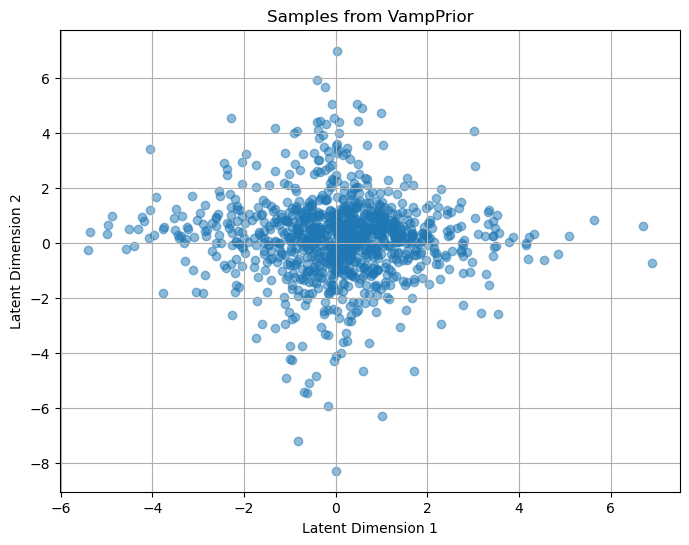

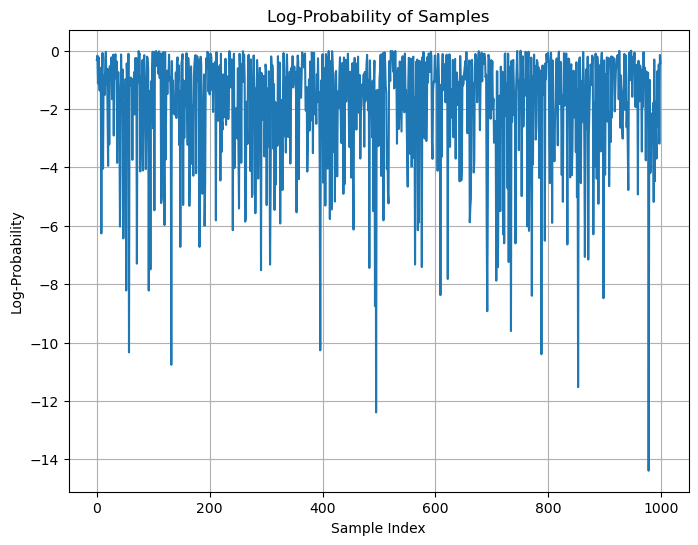

In [5]:
import random
import math
import matplotlib.pyplot as plt

class VampPrior:
    def __init__(self, L, D, num_vals, num_components, encoder):
        self.L = L
        self.D = D
        self.num_vals = num_vals
        self.encoder = encoder
        self.num_components = num_components
        self.u = [[random.uniform(0, self.num_vals) for _ in range(D)] for _ in range(num_components)]
        self.w = [random.uniform(0, 1) for _ in range(num_components)]
        self.w_sum = sum(self.w)
        self.w = [w / self.w_sum for w in self.w]

    def get_params(self):
        mean_vampprior, logvar_vampprior = self.encoder(self.u)
        return mean_vampprior, logvar_vampprior

    def sample(self, batch_size):
        mean_vampprior, logvar_vampprior = self.get_params()
        indexes = [self._sample_mixture() for _ in range(batch_size)]
        z = []
        for i in range(batch_size):
            indx = indexes[i]
            eps = [random.gauss(0, 1) for _ in range(self.L)]
            sample = [mean_vampprior[indx][j] + eps[j] * math.exp(logvar_vampprior[indx][j]) for j in range(self.L)]
            z.append(sample)
        return z

    def log_prob(self, z):
        mean_vampprior, logvar_vampprior = self.get_params()
        log_p = []
        for sample in z:
            log_prob_sample = float('-inf')
            for k in range(self.num_components):
                log_p_k = self._log_normal_diag(sample, mean_vampprior[k], logvar_vampprior[k])
                log_p_k += math.log(self.w[k])
                log_prob_sample = self._logsumexp(log_prob_sample, log_p_k)
            log_p.append(log_prob_sample)
        return log_p

    def _sample_mixture(self):
        r = random.random()
        cumulative_prob = 0.0
        for i, weight in enumerate(self.w):
            cumulative_prob += weight
            if r < cumulative_prob:
                return i
        return len(self.w) - 1

    def _log_normal_diag(self, x, mean, logvar):
        var = [math.exp(lv) for lv in logvar]
        log_p = 0.0
        for i in range(self.L):
            log_p -= 0.5 * ((x[i] - mean[i]) ** 2) / var[i] + logvar[i]
        return log_p

    def _logsumexp(self, log_a, log_b):
        if log_a > log_b:
            return log_a + math.log(1 + math.exp(log_b - log_a))
        else:
            return log_b + math.log(1 + math.exp(log_a - log_b))

# Dummy encoder function
def dummy_encoder(u):
    L = 2
    mean = [[random.uniform(-1, 1) for _ in range(L)] for _ in range(len(u))]
    logvar = [[random.uniform(-1, 1) for _ in range(L)] for _ in range(len(u))]
    return mean, logvar

# Initialize VampPrior
L = 2
D = 10
num_vals = 5
num_components = 16
encoder = dummy_encoder
vamp_prior = VampPrior(L, D, num_vals, num_components, encoder)

# Sample from VampPrior
batch_size = 1000
z = vamp_prior.sample(batch_size)

# Plotting the samples
z1 = [sample[0] for sample in z]  # Extract first dimension
z2 = [sample[1] for sample in z]  # Extract second dimension

# Plot the samples in 2D latent space
plt.figure(figsize=(8, 6))
plt.scatter(z1, z2, alpha=0.5)
plt.title('Samples from VampPrior')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.grid(True)
plt.show()

# Compute log-probability of the samples
log_prob = vamp_prior.log_prob(z)

# Plot log-probability vs sample index
plt.figure(figsize=(8, 6))
plt.plot(range(batch_size), log_prob)
plt.title('Log-Probability of Samples')
plt.xlabel('Sample Index')
plt.ylabel('Log-Probability')
plt.grid(True)
plt.show()
